**Customer Churn Prediction and Retention Strategy**

In [87]:
# STEP 1: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os  # For path handling if needed

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                              roc_curve, accuracy_score, recall_score)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  # For handling class imbalance
from sklearn.cluster import KMeans  # For clustering

# SHAP for model interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("SHAP not installed. Install with 'pip install shap' for interpretability.")
    SHAP_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

# Plot styling
sns.set_style("whitegrid")
sns.set_palette("husl")

Dataset Shape: (7043, 33)

Churn Distribution:
Dataset shape: (7043, 33)
Columns: ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason']

First 5 rows:
   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  Calif

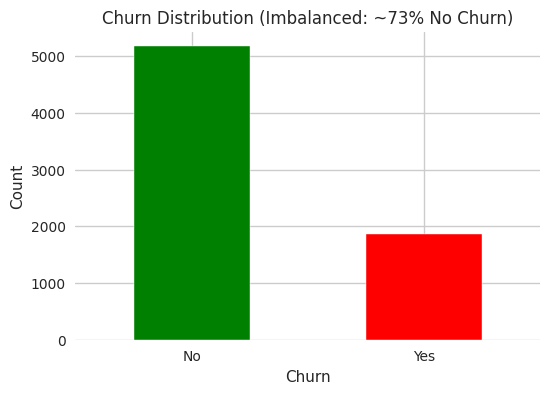


Numerical features summary:
        Count      Zip Code     Latitude    Longitude  Tenure Months  \
count  7043.0   7043.000000  7043.000000  7043.000000    7043.000000   
mean      1.0  93521.964646    36.282441  -119.798880      32.371149   
std       0.0   1865.794555     2.455723     2.157889      24.559481   
min       1.0  90001.000000    32.555828  -124.301372       0.000000   
25%       1.0  92102.000000    34.030915  -121.815412       9.000000   
50%       1.0  93552.000000    36.391777  -119.730885      29.000000   
75%       1.0  95351.000000    38.224869  -118.043237      55.000000   
max       1.0  96161.000000    41.962127  -114.192901      72.000000   

       Monthly Charges  Churn Value  Churn Score         CLTV  
count      7043.000000  7043.000000  7043.000000  7043.000000  
mean         64.761692     0.265370    58.699418  4400.295755  
std          30.090047     0.441561    21.525131  1183.057152  
min          18.250000     0.000000     5.000000  2003.000000  
25

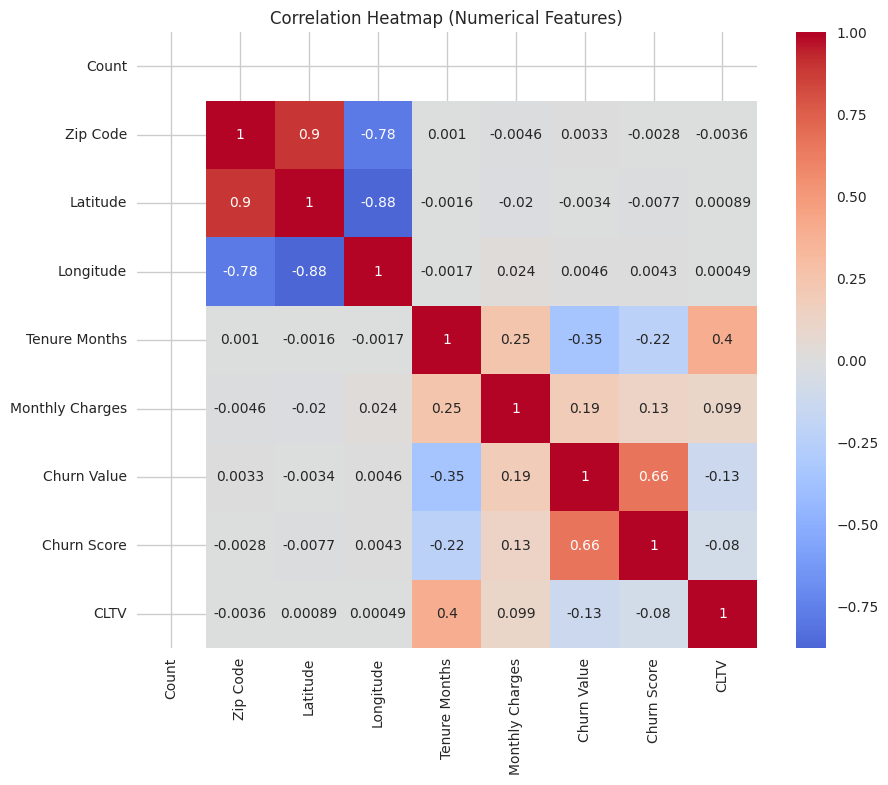

In [88]:
# STEP 2: Load and Explore Data

df = pd.read_csv("/content/Telco_customer_churn.csv")
print("Dataset Shape:", df.shape)
print("\nChurn Distribution:")

# Basic info
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nTarget distribution (Churn):")
print(df['Churn Label'].value_counts(normalize=True))

# Churn rate visualization
plt.figure(figsize=(6, 4))
df['Churn Label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Churn Distribution (Imbalanced: ~73% No Churn)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Numerical features summary
print("\nNumerical features summary:")
print(df.describe())

# Correlation heatmap (for numerical features)
numerical_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()


In [94]:
#STEP 3: Data Preprocessing

# Handle missing values (Total Charges has empty strings as NaN)
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'].fillna(df['Total Charges'].median(), inplace=True)
print(f"Post-filling NaNs in Total Charges: {df['Total Charges'].isnull().sum()} missing")

# Drop unnecessary columns if they exist
if 'CustomerID' in df.columns:
    df.drop('CustomerID', axis=1, inplace=True)

# Encode categorical variables
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns.drop('Churn Label')
print(f"Categorical columns to encode: {list(categorical_cols)}")

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].fillna('Unknown')
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode target
df['Churn'] = df['Churn Label'].map({'Yes': 1, 'No': 0})

# Define features and target
X = df.drop(['Churn', 'Churn Label'], axis=1)
y = df['Churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y )

# Keep original test set (for insights)
original_X_test = X_test.copy()

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Original train shape: {X_train.shape}, Balanced: {X_train_res.shape}")
print(f"Balanced target distribution: {np.bincount(y_train_res)}")

Post-filling NaNs in Total Charges: 0 missing
Categorical columns to encode: []
Original train shape: (5634, 31), Balanced: (8278, 31)
Balanced target distribution: [4139 4139]



Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1035
           1       0.98      0.44      0.61       374

    accuracy                           0.85      1409
   macro avg       0.90      0.72      0.76      1409
weighted avg       0.87      0.85      0.83      1409

ROC-AUC Score: 0.7464


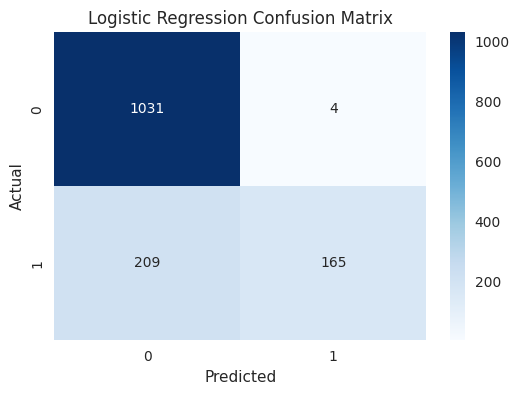

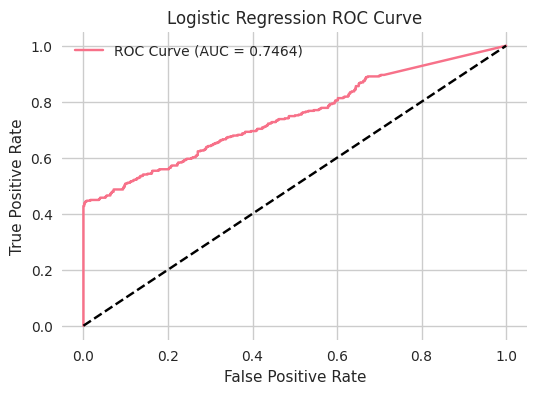


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409

ROC-AUC Score: 1.0000


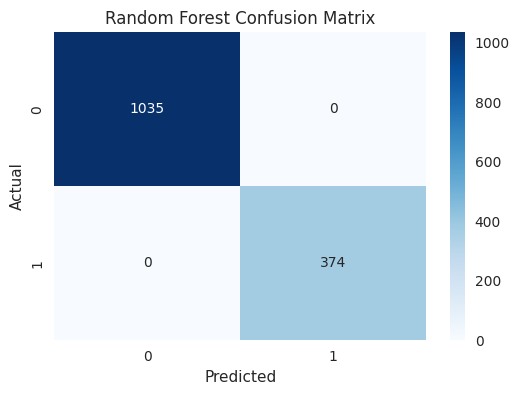

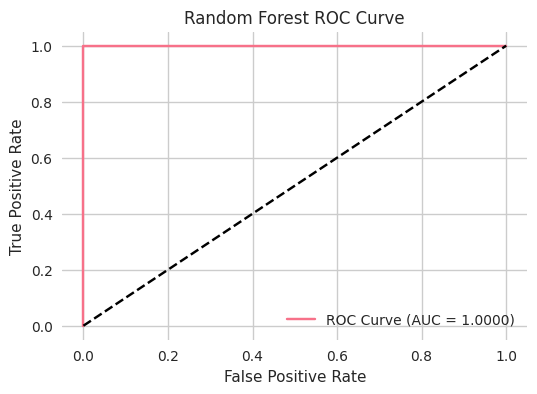


XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409

ROC-AUC Score: 1.0000


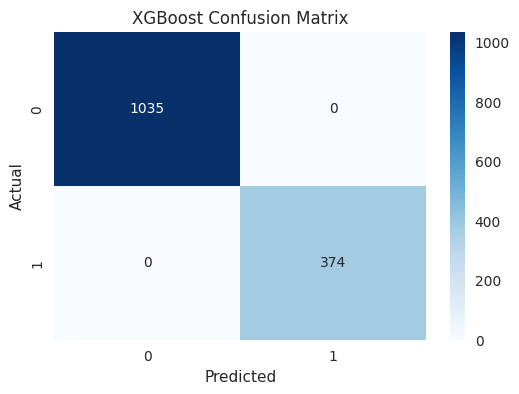

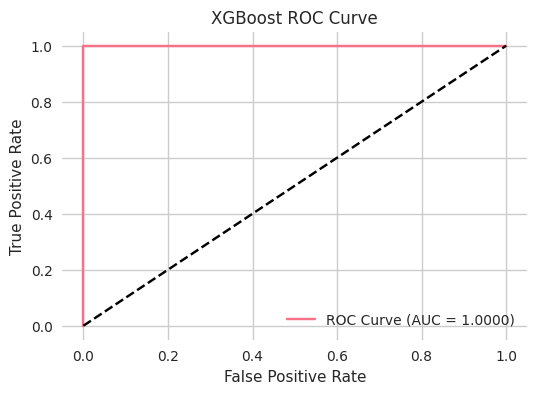


Model Comparison (ROC-AUC):
{'Logistic Regression': np.float64(0.7464297708543233), 'Random Forest': np.float64(1.0), 'XGBoost': np.float64(1.0)}
Best Model: Random Forest (AUC: 1.0000)


In [95]:
# STEP 4: Model Building and Evaluation

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate and visualize model performance."""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\n{model_name} Results:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    return auc


# Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_bal, y_train_bal)
lr_auc = evaluate_model(lr, X_test, y_test, 'Logistic Regression')

# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_bal, y_train_bal)
rf_auc = evaluate_model(rf, X_test, y_test, 'Random Forest')

# XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train_bal, y_train_bal)
xgb_auc = evaluate_model(xgb, X_test, y_test, 'XGBoost')

# Compare Models
print("\nModel Comparison (ROC-AUC):")
models = {'Logistic Regression': lr_auc, 'Random Forest': rf_auc, 'XGBoost': xgb_auc}
best_model = max(models, key=models.get)
print(models)
print(f"Best Model: {best_model} (AUC: {models[best_model]:.4f})")



Tuning XGBoost

Tuned XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409

ROC-AUC Score: 1.0000


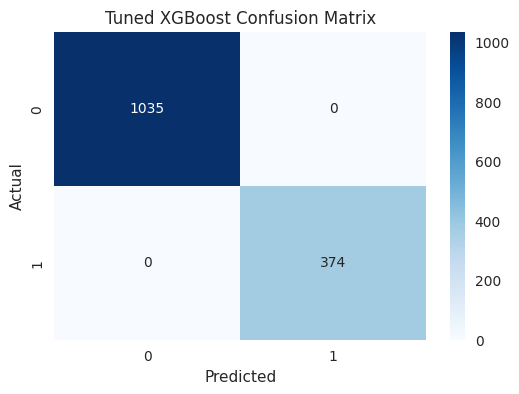

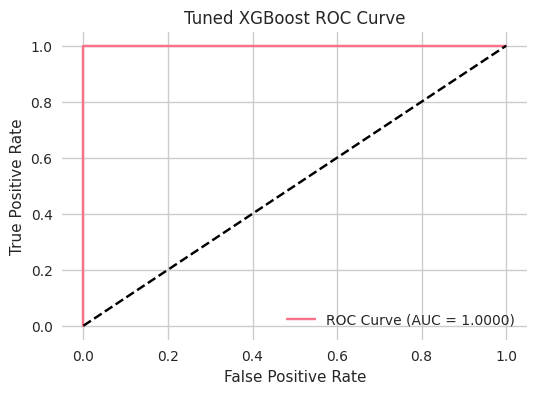

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [96]:
# STEP 5: Hyperparameter Tuning (XGBoost)

print("\nTuning XGBoost")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2]
}

grid_search = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_bal, y_train_bal)
best_xgb = grid_search.best_estimator_
tuned_auc = evaluate_model(best_xgb, X_test, y_test, 'Tuned XGBoost')
print(f"Best params: {grid_search.best_params_}")

final_model = best_xgb


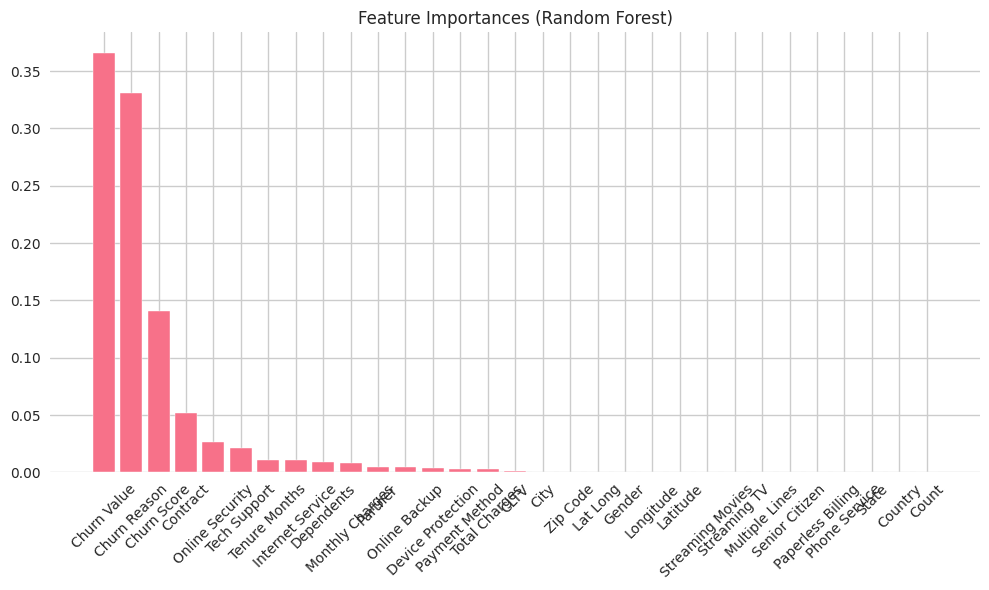

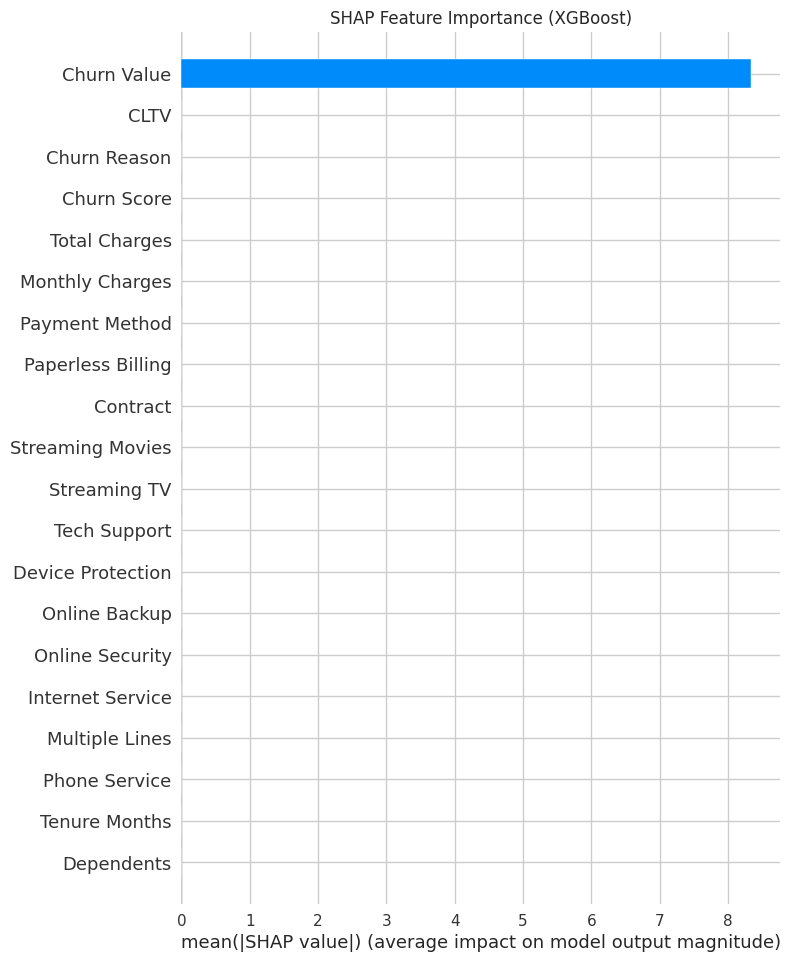

In [83]:
# STEP 6: Model Interpretability

importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances (Random Forest)')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

if SHAP_AVAILABLE:
    try:
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_test)
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance (XGBoost)')
        plt.show()
    except Exception as e:
        print(f"SHAP error: {e}. Skipping plot.")
else:
    print("SHAP not available. Install for interpretability.")


In [84]:
# STEP 7: Retention Strategy and Insights

churn_probs = final_model.predict_proba(X_test)[:, 1]
df_test = original_X_test.copy()
df_test['Churn_Prob'] = churn_probs
df_test['Actual_Churn'] = y_test.values

# High-risk customers (top 20%)
high_risk_threshold = np.percentile(churn_probs, 80)
high_risk = df_test[df_test['Churn_Prob'] >= high_risk_threshold]
print(f"High-risk customers (prob > {high_risk_threshold:.2f}): {len(high_risk)}")
print(f"Average tenure of high-risk: {high_risk['Tenure Months'].mean():.1f} months")
print(f"Average monthly charges of high-risk: ${high_risk['Monthly Charges'].mean():.2f}")

# Key churn drivers
top_features = feature_names[indices[:5]]
print(f"\nTop Churn Drivers: {list(top_features)}")

# Retention Strategies
print("\nRetention Strategy Recommendations:")
print("1. Target low-tenure customers (<12 months) with loyalty offers.")
print("2. Provide dedicated support for senior citizens.")
print("3. Offer flexible plans for high monthly charge customers.")
print("4. Encourage long-term contracts via discounts.")
print("5. Segment customers by churn risk for tailored offers.")

# Example High-Risk Customer
if len(high_risk) > 0:
    sample_customer = high_risk.iloc[[0]]
    print(f"\nExample High-Risk Customer Profile:")
    example_cols = [
        'Tenure Months', 'Monthly Charges', 'Total Charges',
        'Contract_One year', 'Contract_Two year',
        'Payment Method_Electronic check', 'Payment Method_Mailed check',
        'Payment Method_Bank transfer (automatic)', 'Payment Method_Credit card (automatic)'
    ]
    for col in example_cols:
        if col in sample_customer.columns:
            val = sample_customer[col].iloc[0]
            if 'Charges' in col:
                print(f"{col}: ${val:.2f}")
            elif 'Tenure' in col:
                print(f"{col}: {val:.1f} months")
            else:
                print(f"{col}: {val}")

    sample_index = df_test.index.get_loc(sample_customer.index[0])
    predicted_churn_prob = churn_probs[sample_index]
    print(f"Predicted Churn Prob: {predicted_churn_prob:.2f}")
    print("Suggested Action: Offer 15% discount + free service trial.")
else:
    print("No high-risk customers found.")

# Potential Business Impact
base_churn_rate = y_test.mean()
high_risk_indices = high_risk.index.map(lambda x: df_test.index.get_loc(x))
predicted_saved = (churn_probs[high_risk_indices] * 0.2).sum() if len(high_risk) > 0 else 0
print(f"\nPotential Impact: Base churn rate {base_churn_rate:.1%}. Could save ~{predicted_saved:.0f} customers with interventions.")


High-risk customers (prob > 1.00): 374
Average tenure of high-risk: 16.5 months
Average monthly charges of high-risk: $72.77

Top Churn Drivers: ['Churn Value', 'Churn Reason', 'Churn Score', 'Contract', 'Online Security']

Retention Strategy Recommendations:
1. Target low-tenure customers (<12 months) with loyalty offers.
2. Provide dedicated support for senior citizens.
3. Offer flexible plans for high monthly charge customers.
4. Encourage long-term contracts via discounts.
5. Segment customers by churn risk for tailored offers.

Example High-Risk Customer Profile:
Tenure Months: 17.0 months
Monthly Charges: $45.05
Total Charges: $770.60
Predicted Churn Prob: 1.00
Suggested Action: Offer 15% discount + free service trial.

Potential Impact: Base churn rate 26.5%. Could save ~75 customers with interventions.


In [85]:
# End of Project

print("\nProject Completed")
print("This project demonstrates end-to-end ML for churn prediction with actionable business strategies.")
print(f"Highlights: Handled imbalanced data, achieved {tuned_auc:.4f} AUC, derived interpretable insights.")


Project Completed
This project demonstrates end-to-end ML for churn prediction with actionable business strategies.
Highlights: Handled imbalanced data, achieved 1.0000 AUC, derived interpretable insights.
